# Lab 1: Cyberbullying Detection Using AI - Hyperparameter Tuning

## Section 0: Download required tools and files

First, we need to download softwares used in the lab. Just hit the 'play' button run the code below.

In [ ]:
!git clone https://github.com/nishantvishwamitra/CyberbullyingLab1.git

Next, we install Pytorch, a framework for training and deploying AI technologies.

In [ ]:
!pip install conda
!conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch
!pip install torchtext==0.11.0

Let's import all our softwares dependencies in our iPython notebook

In [ ]:
SEED = 1234
import torch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
from torchtext.legacy import data
import os
import random
random.seed(SEED)
import pandas as pd
import numpy as np
np.random.seed(SEED)

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchtext
import nltk
from sklearn.metrics import classification_report, confusion_matrix
import spacy
from CyberbullyingLab1.models import LSTM
import matplotlib.pyplot as plt

import locale
locale.getpreferredencoding = lambda: "UTF-8"

## Section 1: Dataset

While training AI, datasets are divided into three parts: training dataset, testing dataset and validation dataset. Let's create these three parts for our dataset.

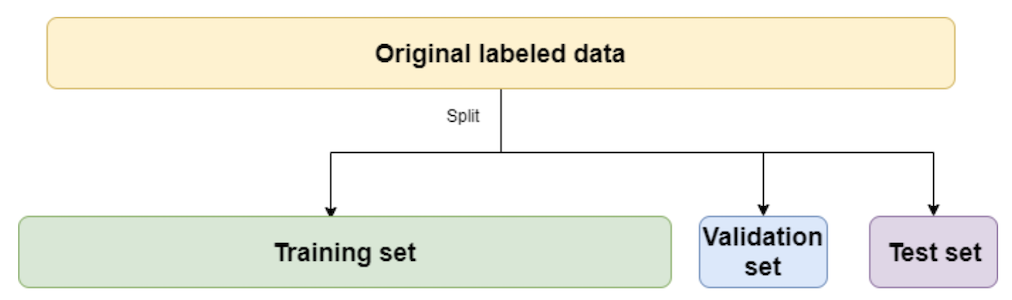

In [ ]:
main_df = pd.read_csv('CyberbullyingLab1/formspring_dataset.csv', sep = '\t')

# Let's see how many smaples we have
print('Total number of samples:', main_df.shape)
main_df = main_df.sample(n = main_df.shape[0])
main_df = main_df[['text', 'label']]

# Let's take a look at a few samples from our dataset
print(main_df.head())

# let's create train, val and test splits
train_val = main_df.iloc[:int(main_df.shape[0] * .80)]
test = main_df.iloc[int(main_df.shape[0] * .80):]
train = train_val.iloc[:int(train_val.shape[0] * .80)]
val = train_val.iloc[int(train_val.shape[0] * .80):]

print('\nTraining set:\n', train.label.value_counts())
print('\nValidation set:\n', val.label.value_counts())
print('\nTest set:\n', test.label.value_counts())

# write the train, test and validation splits to file
train.to_csv("CyberbullyingLab1/dataset/train.csv", index = False)
test.to_csv("CyberbullyingLab1/dataset/test.csv", index = False)
val.to_csv("CyberbullyingLab1/dataset/valid.csv", index = False)


The first step in natural language processing for AI is tokenization. In this process, we split the text into 'tokens', that are then given unique numbers that are understood by a machine. Take a look at the example below.

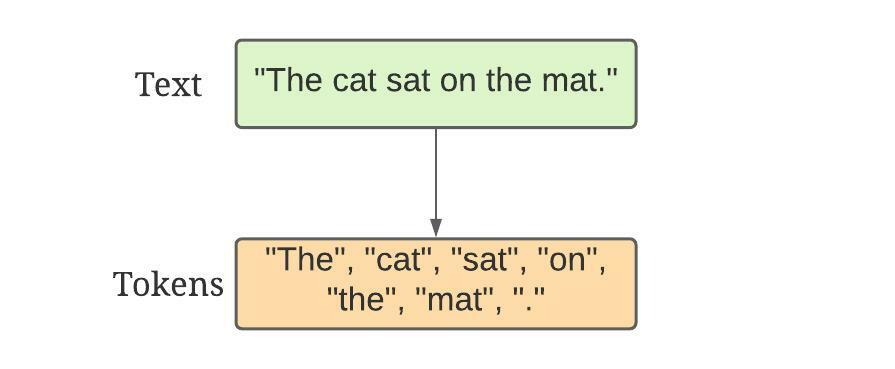

In [ ]:
# Let's use a tokenizer. This is the first step in NLP
spacy_en = spacy.load('en_core_web_sm')

Let's see what tokenization does to the text below. 

In [ ]:
# Convert string to a list of words
spacy_en = spacy.load('en_core_web_sm')
text = spacy_en("The cat sat on the mat.")
tokens = [token for token in text]
print(tokens)

We will use a GPU to train our AI if it is available.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Load the train, validation and test datasets that we prepared.

In [ ]:
# Loading train, test and validation data 
TEXT = data.Field(sequential = True, tokenize = 'spacy')
LABEL = data.LabelField(dtype = torch.long, sequential = False)
train_data, validation_data, test_data = data.TabularDataset.splits(
  path = "CyberbullyingLab1/dataset/", train = "train.csv",
  validation = "valid.csv", test = "test.csv", format = "csv", skip_header = True,
  fields=[('Text', TEXT), ('Label', LABEL)]
)

print(f'Number of training examples: {len(train_data)}')
print(f'Number of valid examples: {len(validation_data)}')
print(f'Number of testing examples: {len(test_data)}')

## Section 2: Dataset iterator

We need iterators to step through our dataset. 
You can learn more about PyTorch BucketIterator [here](https://gmihaila.medium.com/better-batches-with-pytorchtext-bucketiterator-12804a545e2a)

In [ ]:
BATCH_SIZE = 20
train_iterator, validation_iterator, test_iterator = data.BucketIterator.splits(
                (train_data, test_data, validation_data), sort_key=lambda x: len(x.Text),
                 batch_sizes=(BATCH_SIZE, BATCH_SIZE, BATCH_SIZE), sort=False, shuffle=False, 
                 sort_within_batch=True, device=device)

In [ ]:
print(f'Created train_iterator with {len(train_iterator)} batches!')
print(f'Created validation_iterator with {len(validation_iterator)} batches!')
print(f'Created test_iterator with {len(test_iterator)} batches!')

## Section 3: Embedding 

Let's build the vocabulary of our cyberbullying dataset. We first need some pretrained embeddings. Let's define functions that will download them for use in the embedding task later. The figure shows how embeddings look like in higher dimensional space.

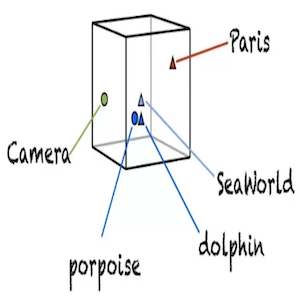

In [ ]:
def pretrained_default_embedding(print_token=True):
    """Downloads the custom 100 dimensional pretrained embedding we trained specifically for this lab and builds a vocabulary from it
    Arguments: 
        print_token - Boolean: If true, prints the number of unique text and label vocabulary. Otherwise nothing is printed
    Returns:
        None
    """
    if not os.path.exists("zo6yotsu3kl2cpoiej4s6femxci2ouql.txt"):
    #   !wget https://github.com/cuadvancelab/materials/blob/main/lab1/glove.6B.100d.txt?raw=true
        !wget https://buffalo.box.com/shared/static/zo6yotsu3kl2cpoiej4s6femxci2ouql.txt
    print()
    
    # Build the vocabulary using our train dataset and embedding
    TEXT.build_vocab(train_data, vectors = torchtext.vocab.Vectors('glove.6B.100d.txt?raw=true'), max_size = 20000, min_freq = 10)
    LABEL.build_vocab(train_data)
    
    if print_token:
        print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
        print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Embedding can have different dimensions, the following loads the 200-d Twitter embedding.  

In [ ]:
def pretrained_twitter_embedding(print_token=True):
    """Downloads the 200 dimensional Twitter pretrained embedding and builds a vocabulary from it
    Arguments: 
        print_token - Boolean: If true, prints the number of unique text and label vocabulary. Otherwise nothing is printed
    Returns:
        None
    """
    
    if not os.path.exists("/content/glove/glove.twitter.27B.200d.txt"):
      !wget https://nlp.stanford.edu/data/glove.twitter.27B.zip
      !unzip -q glove.twitter.27B.zip -d /content/glove/
    print()
    
    # Build the vocabulary using our train dataset and embedding
    TEXT.build_vocab(train_data, vectors = torchtext.vocab.Vectors('/content/glove/glove.twitter.27B.200d.txt'), max_size = 20000, min_freq = 10)
    LABEL.build_vocab(train_data)
    
    if print_token:
        print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
        print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

In [ ]:
def view_batches(iterator):
    """
    Prints the examples in a few batches 
    Args:
        iterator: a train, validation or test iterator 
    Returns:
        None
    """
    # Vocabulary needs to be built for this function to work
    pretrained_default_embedding() 

    # Loop through BucketIterator.
    print('\n PyTorchText BuketIterator\n')

    for i, batch in enumerate(iterator, 1):
        # Let's check batch size.
        print(f'Batch size: {len(batch)}')
        print(f'Label: \n {batch.Label}')
        print(f'length: {len(batch.Text)}')
        print(f'Text: \n {batch.Text}')
        print('Text\n')
        
        examples = batch.Text
        token_indices = TEXT.vocab.itos
        for j in range(examples.shape[1]):
            example = examples[:, j].tolist()
            tokens = []
            for token_index in example:
                tokens.append(token_indices[token_index])
            print(" ".join(tokens))
        print('\n')
        
        # Look at the first 2 batches
        if i == 2:
            break

# Look at a few batches 
view_batches(train_iterator)

##Section 4: Utilities

Let's define the training and testing procedures for our AI model

In [ ]:
def binary_accuracy(preds, y):
    """
    Computes the accuracy of the model
    Arguments:
        preds: a (Tensor) of predicted values from the model having shape (batch size, num_examples)
        y: the true labels of the current batch of examples
    Returns:
        acc: (float) - the accuracy 
    """
    preds, ind= torch.max(F.softmax(preds, dim=-1), 1)
    correct = (ind == y).float()
    acc = correct.sum()/float(len(correct))
    return acc

# Lets define our training steps
def train(model, iterator, optimizer, criterion):
    """
    Trains the model on the whole train dataset
    Arguments:
        model - model to be trained
        iterator - an iterator over the train dataset
        optimizer - optimization function 
        criterion - loss function
    Returns:
        epoch_loss: (float) - the average loss after going through
        the entire train dataset for the current epoch
        epoch_acc: (float) - the avergae accuracy after going through
        the entire train dataset for the current epoch
    """

    epoch_loss = 0
    epoch_acc = 0

    model.train()
    
    for batch in iterator:
        # PyTorch accumulates gradients, zero them out before batch iteration
        optimizer.zero_grad()
        
        # Compute predictions and loss
        predictions = model(batch.Text).squeeze(0)
        loss = criterion(predictions, batch.Label)
        
        # Compute accuracy
        acc = binary_accuracy(predictions, batch.Label)
       
        # Back propagate throught the network
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    """
    Tests how well the model is doing on the validation dataset
    Arguments:
        model - model to be trained
        iterator - an iterator over the validation dataset
        criterion - loss function
    Returns:
        epoch_loss: (float) - the average loss after going through
        the entire validation dataset for the current epoch
        epoch_acc: (float) - the avergae accuracy after going through
        the entire validation dataset for the current epoch
    """
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            # Compute predictions and loss
            predictions = model(batch.Text).squeeze(0)
            loss = criterion(predictions, batch.Label)
            # Compute accuracy
            acc = binary_accuracy(predictions, batch.Label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def compute_metrics(model, test_iterator):
    """
    Prints various metrics on our test dataset
    Arguments: 
        model: trained model 
        test_iterator: an iterator over the test dataset
    Returns: None
    """
    y_predicted = []
    y_true = []
   
    for batch in test_iterator:
        predictions = model(batch.Text).squeeze(0)
        prediction_values, predicted = torch.max(F.softmax(predictions, dim=-1), 1)
        y_predicted.extend(predicted.tolist())
        y_true.extend(batch.Label.tolist())
    
    # Compute precision, recall and f1-score
    target_names = ["Non-Cyberbully", "Cyberbully"]
    print(classification_report(y_true=y_true, y_pred=y_predicted, target_names=target_names))

    # Compute true positive, true negative, false positive and false negative
    true_negative, false_positive, false_negative, true_positive = confusion_matrix(y_true, y_predicted).ravel()
    print(f"True positive: {true_positive} \n False positive: {false_positive} \n True negative: {true_negative} \n False negative: {false_negative}")

## Section 5: Model 
Let's instantiate our AI model.

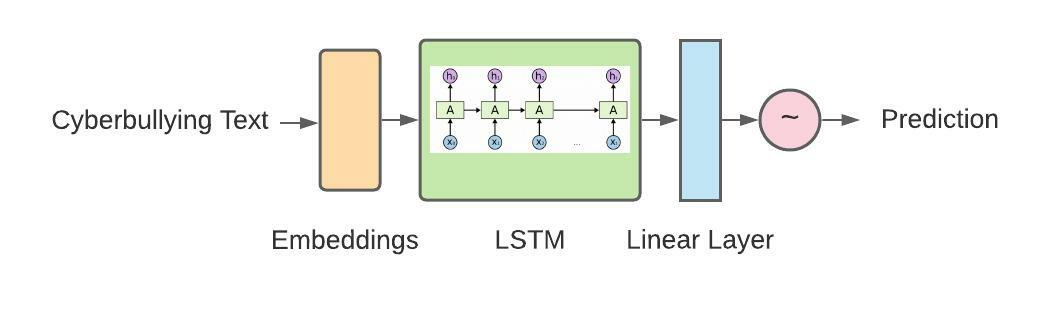

In [ ]:
def build_model(input_dim, embedding_dim=100, hidden_dim=374, output_dim=2, print_model=True):
    """
    Builds our model graph
    Arguments:
        input_dim: the size of our text vocabulary
        embedding_dim: the embedding dimension, defaults to 100
        hidden_dim: the hidden layer dimension, defaults to 374
        output_dim: the output dimension, defaults to 2
    Returns:
        model: model graph object
    """  
    model = LSTM(input_dim, embedding_dim, hidden_dim, output_dim)
    if print_model:
        print(model)
    return model

In [ ]:
# test build_model
model = build_model(10, print_model=True)

## Section 6: Training function

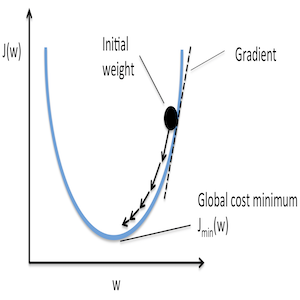

Let's setup our training procedure.

In [ ]:
def train_model(model, train_iterator, validation_iterator, number_of_epochs, learning_rate=1e-3, verbose=True):
    """
    Trains our AI model and plots the learning curve
    Arguments:
        model: model to be trained
        train_iterator: an iterator over the training set
        validation_iterator: an iterator over the validation set
        number_of_epochs: The number of times to go through our entire dataset
        optimizer: the optimization function, defaults to None
        criterion: the loss function, defaults to None
        learning_rate: the learning rate, defaults to 0.001
        verbose: Boolean - whether to print accuracy and loss
    Returns:
        learning_curve: Dictionary - contains variables for plotting the learning curve 
    """

    # initialize variables for plotting 
    epochs = [i for i in range(number_of_epochs)]
    train_losses = []
    validation_losses = []
    validation_accs = []
    
    #Let's define an optimizer and loss function for training our AI
    class_weights = torch.tensor([1.0, 14.0]).to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    model = model.to(device)
    criterion = criterion.to(device)  

    for epoch in range(number_of_epochs):
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
        validation_loss, validation_acc = evaluate(model, validation_iterator, criterion)
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        validation_accs.append(validation_acc)
        
        if verbose:
            print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {validation_loss:.3f} | Val. Acc: {validation_acc*100:.2f}% |')

    test_loss, test_acc = evaluate(model, test_iterator, criterion)
    if verbose:
        print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')
    print()
    
    epochs = np.asarray(epochs)
    train_losses = np.asarray(train_losses)
    validation_losses = np.asarray(validation_losses)
    validation_accs = np.asarray(validation_accs)

    learning_curve = {"train_losses": train_losses,
                      "validation_losses": validation_losses,
                      "epochs": epochs,
                      "learning_rate": learning_rate,
                      "validation_accs": validation_accs}

    return learning_curve

If you are not running on Google Collab and get a "CUDA error: no kernel image is available for execution on the device" error after runing the third cell below, the GPU you are running on has a compute capability (CC) of 3.5. This is  a PyTorch issue and a common error if you are using the K40 GPU series. You can check the CC of your GPU [here](https://developer.nvidia.com/cuda-gpus#compute). Resolve this issue by using a GPU with CC>=3.7


In [ ]:
# Initialization
embedding_dim = 100
hidden_dim = 374
output_dim = 2
number_of_epochs = 15
input_dim = len(TEXT.vocab)

In [ ]:
# Download and initialize embeddings
pretrained_default_embedding()

In [ ]:
# Build model and train
model = build_model(input_dim, embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=output_dim, print_model=True)
_ = train_model(model, train_iterator, validation_iterator, number_of_epochs, learning_rate=1e-3, verbose=True)

## Section 7: Hyperparameter tuning

### **<font color='red'>Task 5:</font> With the default hyperparameters**
**Note: Run all the previous cells above before continuing.**

In [ ]:
# The default embeddings
pretrained_default_embedding()

Let's define some hyperparameters for our AI model.

In [ ]:
# The default hyperparameters
embedding_dim = 100
hidden_dim = 374
output_dim = 2
number_of_epochs = 15
learning_rate = 0.001

In [ ]:
# Build model
model = build_model(len(TEXT.vocab), embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=output_dim, print_model=True)
print_more_model_info = False
if print_more_model_info:
    print(f"\n model weights (random) before loading the pretrained weights:\n {model.embedding.weight}  \t shape: {model.embedding.weight.shape} \n")
    
    # We will use the pretrained embeddings that we downloaded in our model.
    pretrained_embeddings = TEXT.vocab.vectors
    model.embedding.weight.data = pretrained_embeddings.to(device)
    
    # We don't want to train the embedding, we already have a pretrained embedding. 
    model.embedding.weight.requires_grad = False
    print(f"model weights after loading the pretrained weights: \n {model.embedding.weight} \t shape: {model.embedding.weight.shape}")
else:
    pretrained_embeddings = TEXT.vocab.vectors
    model.embedding.weight.data = pretrained_embeddings.to(device)
    model.embedding.weight.requires_grad = False

In [ ]:
# train
learning_curve = train_model(model, train_iterator, validation_iterator, number_of_epochs, learning_rate=learning_rate)

#plot learning curve
plt.plot(learning_curve["epochs"], learning_curve["train_losses"], label='training')
plt.plot(learning_curve["epochs"], learning_curve["validation_losses"], label='validation')  
plt.xlabel('epochs')
plt.ylabel('loss.')
plt.title(f"With hidden dimension = {hidden_dim} AND number of epochs = {number_of_epochs}")
plt.legend()

### **<font color='red'>Task 6:</font> With different Hidden Dimensions (150, 500 and 650)**

In [ ]:
# TODO: update the hyperparameters (hidden_dim)
embedding_dim = 100
hidden_dim = 
output_dim = 2
number_of_epochs = 15
learning_rate = 0.001

In [ ]:
# Build model
model = build_model(len(TEXT.vocab), embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=output_dim, print_model=True)
# Train model
learning_curve = train_model(model, train_iterator, validation_iterator, number_of_epochs, learning_rate=learning_rate)

In [ ]:
#plot learning curve
plt.plot(learning_curve["epochs"], learning_curve["train_losses"], label='training') 
plt.plot(learning_curve["epochs"], learning_curve["validation_losses"], label='validation') 
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("Hidden Dimensions = " + str(hidden_dim))
plt.legend()

### **<font color='red'>Task 7:</font> With different Number of Training Epochs**

In [ ]:
# TODO: update the hyperparameters
embedding_dim = 100
hidden_dim = 500
output_dim = 2
number_of_epochs = 
learning_rate = 0.001

In [ ]:
# Build model
model = build_model(len(TEXT.vocab), embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=output_dim, print_model=True)
# Train model
learning_curve = train_model(model, train_iterator, validation_iterator, number_of_epochs, learning_rate=learning_rate)

In [ ]:
50#plot learning curve
plt.plot(learning_curve["epochs"], learning_curve["train_losses"], label='training') 
plt.plot(learning_curve["epochs"], learning_curve["validation_losses"], label='validation') 
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("Numbers of Epochs = " + str(number_of_epochs))
plt.legend()

### **<font color='red'>Task 8:</font> With different Embedding Dimensions**

In [ ]:
# Note: Change to pretrained_twitter_embedding() for the embedding task
pretrained_twitter_embedding()

In [ ]:
# TODO: update the hyperparameters
embedding_dim = 
hidden_dim = 374
output_dim = 2
number_of_epochs = 15
learning_rate = 0.001

In [ ]:
# Build model
model = build_model(len(TEXT.vocab), embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=output_dim, print_model=True)
# Train model
learning_curve = train_model(model, train_iterator, validation_iterator, number_of_epochs, learning_rate=learning_rate)

In [ ]:
#plot learning curve
plt.plot(learning_curve["epochs"], learning_curve["train_losses"], label='training') 
plt.plot(learning_curve["epochs"], learning_curve["validation_losses"], label='validation') 
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("Embedding Dimension = " + str(embedding_dim))
plt.legend()

### **<font color='red'>Task 9:</font> Compare different learning rates**

Learning rate needs to be chosen carefully in order for gradient descent to work properply. How quickly we update the parameters of our models is determined by the learning rate. If we choose the learning rate to be too small, we may need a lot more iteration to converge to the optimal values. If we choose the learning rate to be too big, we may go past our optimal values. So, it is important to choose the learning rate carefully. 

Run the cells below to try different values of learning rate and observe what happens. 

In [ ]:
pretrained_default_embedding()

In [ ]:
embedding_dim = 100
hidden_dim = 374
output_dim = 2
number_of_epochs = 15

In [ ]:
learning_rates = [0.9, 0.1, 0.05, 0.001]
models = {}
for i, learning_rate in enumerate(learning_rates, 1):
    print(f"learning rate: {learning_rate}")
    # Build model
    model = build_model(len(TEXT.vocab), embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=output_dim, print_model=False)
    # We will use the pretrained embeddings that we downloaded in our model.
    pretrained_embeddings = TEXT.vocab.vectors
    model.embedding.weight.data = pretrained_embeddings.to(device)
    # Train
    models[i] = train_model(model, train_iterator, validation_iterator, number_of_epochs, learning_rate=learning_rate, verbose=True)
    print()

for i, learning_rate in enumerate(learning_rates, 1):
    plt.plot(models[i]["epochs"], np.squeeze(models[i]["train_losses"]), label=models[i]["learning_rate"])

plt.ylabel('loss')
plt.xlabel('epochs')

legend = plt.legend(loc='outer', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

### <font color='red'>Task 10:</font> With different Output Dimension 

In [ ]:
# TODO: Try with different output dimesion (output_dim)
#output_dim = 5
embedding_dim = 100
hidden_dim = 374
output_dim = 
number_of_epochs = 15

In [ ]:
# Build model
model = build_model(len(TEXT.vocab), embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=output_dim, print_model=True)
# Train model
learning_curve = train_model(model, train_iterator, validation_iterator, number_of_epochs, learning_rate=learning_rate)

In [ ]:
import pandas as pd
import random
 
# read the data from the downloaded CSV file.
data = pd.read_csv('https://s3-eu-west-1.amazonaws.com/shanebucket/downloads/uk-500.csv')
# set a numeric id for use as an index for examples.
data['id'] = [random.randint(0,1000) for x in range(data.shape[0])]
 
data.head(5)

In [ ]:
print(data.shape)
data.iloc[int(data.shape[0] * .80):]